<a href="https://colab.research.google.com/github/lapshinaaa/recsys-tasks/blob/main/RecSys1_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Recommender Systems YSDA Course (Lapshina Anastasiia) </center></h1>

<img src="https://repository-images.githubusercontent.com/240594243/5eec2380-4f85-11ea-9416-81aa9817d52a" width="1200" />

In [1]:
import os
import zipfile
import requests
import kagglehub

import numpy as np
import polars as pl
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from io import BytesIO
from tqdm.auto import tqdm
from bs4 import BeautifulSoup
from typing import List, Dict
from collections import defaultdict
from scipy.sparse import csr_matrix
from tensorboard.plugins import projector
from concurrent.futures import ThreadPoolExecutor

In [2]:
!ls /content
!ls /content/drive
!ls /content/drive/MyDrive | head

sample_data
ls: cannot access '/content/drive': No such file or directory
ls: cannot access '/content/drive/MyDrive': No such file or directory


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import nbformat

# path = "/content/drive/MyDrive/Colab Notebooks/RecSys1_Intro.ipynb"

# nb = nbformat.read(path, as_version=4)

# if "widgets" in nb.metadata:
#     del nb.metadata["widgets"]
#     print("Removed metadata.widgets ✅")

# nbformat.write(nb, open(path, "w", encoding="utf-8"))
# print("Notebook cleaned and saved ✅")

## MovieLens

Dataset with Movie Rates

[Dataset](https://grouplens.org/datasets/movielens)

[IMDb.com](https://www.imdb.com)

<img src="https://do.ngs.ru/preview/do/155451396e52db853a4618cb0d3a3128_1506429441_1000_666.jpg" width="700" />

### Loading dataset:

In [5]:
def download_and_extract(url: str, filename: str, chunk_size: int = 1024):
    # loading the file
    response = requests.get(url, stream=True)
    response.raise_for_status()

    total_size = int(response.headers.get('content-length', 0))

    # write file
    with open(filename, "wb") as f:
        with tqdm(
            total=total_size,
            unit='B',
            unit_scale=True,
            desc=filename,
            bar_format='{l_bar}{bar:50}{r_bar}{bar:-50b}'  # formatting
        ) as pbar:
            for chunk in response.iter_content(chunk_size=chunk_size):
                if chunk:
                    f.write(chunk)
                    pbar.update(len(chunk))

    # unpacking archive
    with zipfile.ZipFile(filename, "r") as zip_ref:
        print(f"\\Unpacking {filename}...")
        zip_ref.extractall(".")
        print(f"Files from {filename} successfully extracted\n")

In [6]:
download_and_extract(
    url="http://files.grouplens.org/datasets/movielens/ml-32m.zip",
    filename="ml-32m.zip"
)

ml-32m.zip:   0%|                                                  | 0.00/239M [00:00<?, ?B/s]

\Unpacking ml-32m.zip...
Files from ml-32m.zip successfully extracted



In [7]:
movies = pl.read_csv('ml-32m/movies.csv')
links = pl.read_csv('ml-32m/links.csv')
movies = movies.join(links, on='movieId')

movies = movies.rename({'imdbId': 'item_id'})
movies = movies.select(["item_id", "title"])

movies.head()

item_id,title
i64,str
114709,"""Toy Story (1995)"""
113497,"""Jumanji (1995)"""
113228,"""Grumpier Old Men (1995)"""
114885,"""Waiting to Exhale (1995)"""
113041,"""Father of the Bride Part II (1…"


In [8]:
movies_ratings = pl.read_csv('ml-32m/ratings.csv')
movies_ratings = movies_ratings.join(links, on='movieId')
movies_ratings = movies_ratings.rename({'imdbId': 'item_id', 'userId': 'user_id'})
movies_ratings = movies_ratings.select(['user_id', 'item_id', 'rating'])

movies_ratings.head(5)

user_id,item_id,rating
i64,i64,f64
1,114388,4.0
1,113627,1.0
1,112682,2.0
1,115012,5.0
1,114746,5.0


<h2 style="color: rgb(46, 81, 162)">MyAnimeList Database 2020</h2>

Dataset with Anime Rates from website MyAnimeList

[Dataset](https://www.kaggle.com/datasets/hernan4444/anime-recommendation-database-2020)

[MyAnimeList.net](https://myanimelist.net)

<img src="https://i.pinimg.com/originals/53/0b/16/530b16f27752dfbb67c7db8d7b6fae4c.jpg" width="400" />

### Loading dataset:

In [9]:
download_and_extract(
    url="https://www.kaggle.com/api/v1/datasets/download/hernan4444/anime-recommendation-database-2020",
    filename="anime.zip"
)

anime.zip:   0%|                                                  | 0.00/693M [00:00<?, ?B/s]

\Unpacking anime.zip...
Files from anime.zip successfully extracted



In [10]:
anime = pl.read_csv(
    'anime.csv',
    schema_overrides={
        **{"Ranked": pl.Utf8, "Score": pl.Utf8},
        **{f"Score-{i}": pl.Utf8 for i in range(1, 11)}
    }
)

anime = anime.with_columns(
    title=pl.when(pl.col("English name") == "Unknown")
        .then(pl.col("Name"))
        .otherwise(pl.col("English name"))
)

anime = anime.rename({'MAL_ID': 'item_id'})
anime = anime.select(["item_id", "title"])

anime.head()

item_id,title
i64,str
1,"""Cowboy Bebop"""
5,"""Cowboy Bebop:The Movie"""
6,"""Trigun"""
7,"""Witch Hunter Robin"""
8,"""Beet the Vandel Buster"""


In [11]:
anime_ratings = pl.read_csv('rating_complete.csv')
anime_ratings = anime_ratings.rename({'anime_id': 'item_id'})
anime_ratings.head()

user_id,item_id,rating
i64,i64,i64
0,430,9
0,1004,5
0,3010,7
0,570,7
0,2762,9


## Datаset Selection:

In [12]:
# switching between datasets:
DATASET_TYPE = 'MOVIES'
# DATASET_TYPE = 'ANIME'

if DATASET_TYPE == 'ANIME':
    ratings = anime_ratings
    items = anime
elif DATASET_TYPE == 'MOVIES':
    ratings = movies_ratings
    items = movies
else:
    raise IOError("Incorrect Dataset")

## Poster Upload:

In [13]:
class PosterDisplay:
    def __init__(self, dataset_type):
        self.dataset_type = dataset_type.upper()
        self.headers = {"User-Agent": "Mozilla/5.0"}

    def _get_poster_url(self, item_id):
        # processing ID depending on dataset
        if self.dataset_type == 'MOVIES':
            processed_id = str(item_id).zfill(7)
            url = f'https://www.imdb.com/title/tt{processed_id}'
            css_selector = {'class': 'ipc-image'}
            src_attr = 'src'
        else:  # anime on default
            url = f'https://myanimelist.net/anime/{item_id}/'
            css_selector = {'itemprop': 'image'}
            src_attr = 'data-src'

        try:
            response = requests.get(url, headers=self.headers, timeout=10)
            response.raise_for_status()
            soup = BeautifulSoup(response.text, 'html.parser')

            # search element
            poster_element = soup.find('img', css_selector)

            if not poster_element:
                print(f"No poster found for {self.dataset_type} ID {item_id}")
                return None

            return poster_element.get(src_attr)

        except Exception as e:
            print(f"Error fetching {self.dataset_type} URL {item_id}: {e}")
            return None

    def _load_poster(self, row):
        item_id, title = row[0], row[1]
        try:
            poster_url = self._get_poster_url(item_id)

            if not poster_url:
                return None, None

            response = requests.get(poster_url, timeout=10)
            response.raise_for_status()

        except Exception as e:
            print(f"Error loading poster for '{title}': {e}")
            return None, None

        return Image.open(BytesIO(response.content)), title

    def show_posters(self, data):
        data = data[['item_id', 'title']]
        _, axes = plt.subplots(2, 5, figsize=(20, 8))
        rows = [row for row in data.iter_rows()]

        with ThreadPoolExecutor(max_workers=10) as executor:
            results = list(executor.map(self._load_poster, rows))

        for idx, (img, title) in enumerate(results):
            ax = axes[idx // 5, idx % 5]
            if img and title:
                ax.imshow(img)
                ax.set_title(title)
            else:
                ax.set_title("Image not available")
            ax.axis('off')

        plt.tight_layout()
        plt.show()

## 10 top-rated movies:

Writing code that will write top 10 movies/anime movies into the variable top_10

In [14]:
top_10 = (
    ratings
    .group_by("item_id")
    .agg([
        pl.len().alias("n_ratings"),
        pl.col("rating").mean().alias("avg_rating"),
    ])
    .join(
        items.select(["item_id", "title"]).unique(subset=["item_id"]),
        on="item_id",
        how="left"
    )
    .sort(["n_ratings", "avg_rating"], descending=[True, True])
    .select(["item_id", "title"])
    .head(10)
)

In [15]:
top_10

item_id,title
i64,str
111161,"""Shawshank Redemption, The (199…"
109830,"""Forrest Gump (1994)"""
110912,"""Pulp Fiction (1994)"""
133093,"""Matrix, The (1999)"""
102926,"""Silence of the Lambs, The (199…"
76759,"""Star Wars: Episode IV - A New …"
137523,"""Fight Club (1999)"""
107290,"""Jurassic Park (1993)"""
108052,"""Schindler's List (1993)"""


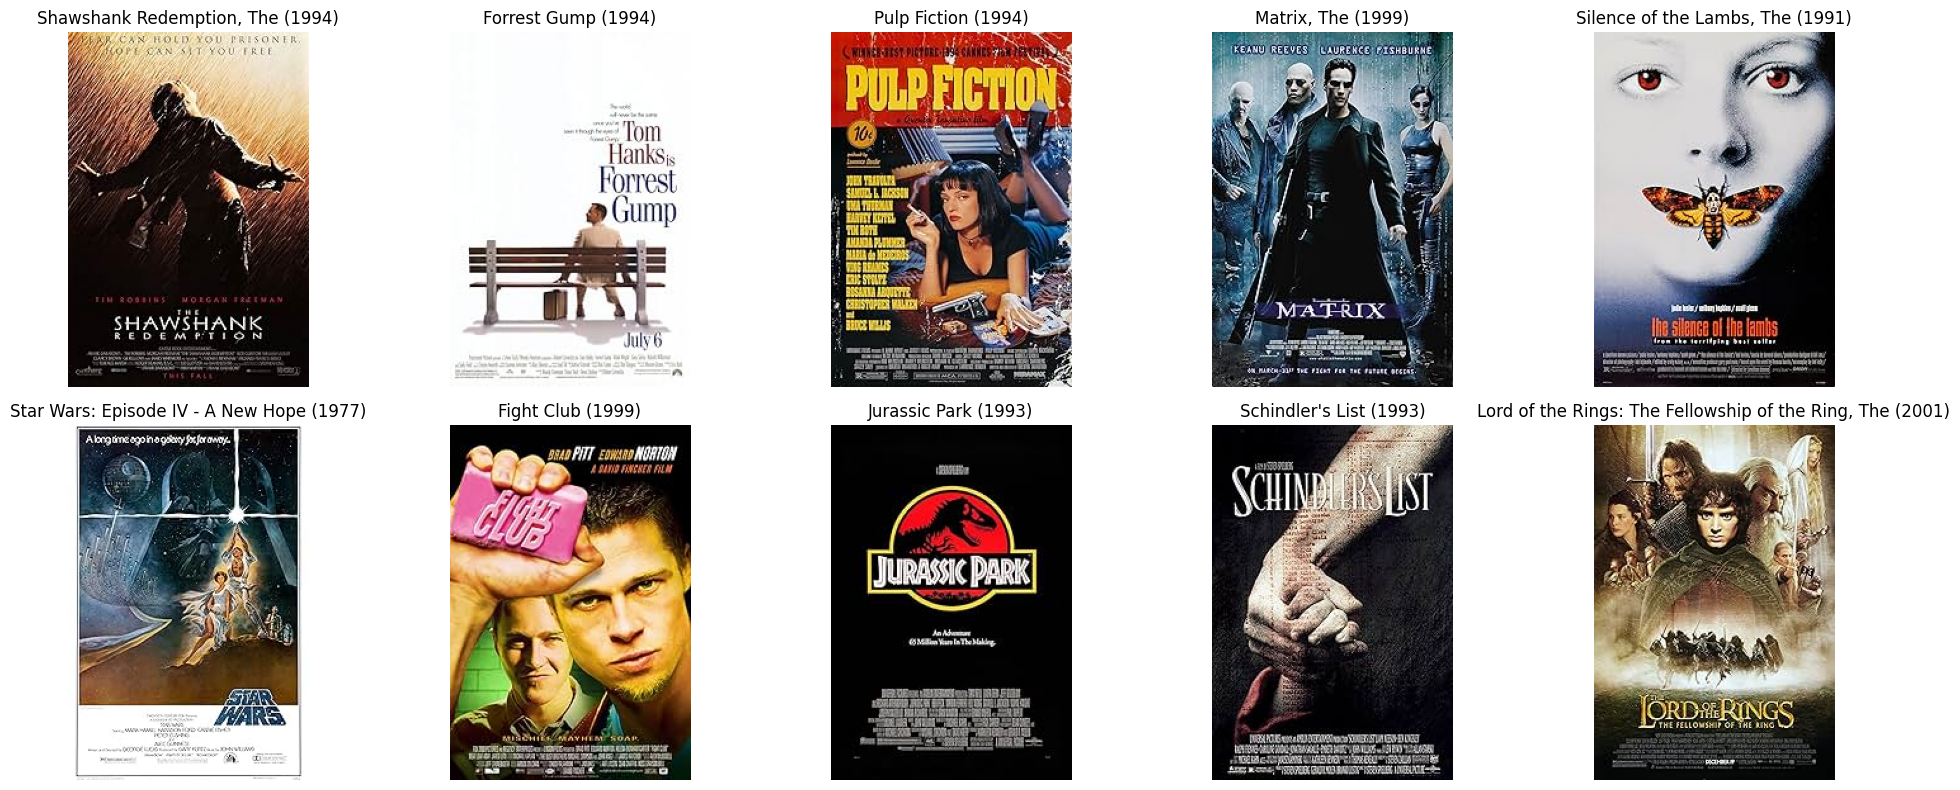

In [16]:
if DATASET_TYPE == 'ANIME':
    assert top_10[0]['item_id'].item() == 1535
    assert top_10[0]['title'].item() == 'Death Note'
else:
    assert top_10[0]['item_id'].item() == 111161
    assert top_10[0]['title'].item() == 'Shawshank Redemption, The (1994)'

assert top_10.shape[0] == 10

display = PosterDisplay(DATASET_TYPE)
display.show_posters(top_10)

### 🧩 Task: Split the Dataset into Train and Test Sets

We will perform the following steps:

1. **Filter out users and items** that have fewer than **20 interactions** in the dataset.  
2. **Select 10 random interactions** from each remaining user to form the **test set**.  
3. **Assign all remaining interactions** to the **train set**.

In [17]:
def train_test_split(ratings: pl.DataFrame) -> tuple[pl.DataFrame, pl.DataFrame]:
    MIN_INTERACTIONS_COUNT = 20
    ITEMS_FOR_TEST = 10

    # filtering out users with fewer than 20 reviews
    users_filter = (
        ratings.group_by("user_id")
        .agg(pl.len())
        .filter(pl.col("len") >= MIN_INTERACTIONS_COUNT)
        .select("user_id")
    )

    # filtering out items with fewer than 20 reviews
    items_filter = (
        ratings.group_by("item_id")
        .agg(pl.len())
        .filter(pl.col("len") >= MIN_INTERACTIONS_COUNT)
        .select("item_id")
    )

    # apply both filters to the data
    filtered_ratings = ratings.join(users_filter, on="user_id").join(items_filter, on="item_id")

    # add necessary columns
    df = filtered_ratings.with_columns(
        row_n=pl.arange(0, pl.len()).over("user_id"),
    )


    train = df.filter(pl.col("row_n") >= ITEMS_FOR_TEST)
    test = df.filter(pl.col("row_n") < ITEMS_FOR_TEST)

    return train.drop(["row_n"]), test.drop(["row_n"])

In [18]:
train, test = train_test_split(ratings[:1000000])

assert train.columns == test.columns == ['user_id', 'item_id', 'rating']

train

user_id,item_id,rating
i64,i64,f64
1,113677,4.0
1,109445,3.0
1,111797,5.0
1,76759,5.0
1,110963,4.0
…,…,…
6502,218839,4.0
6502,210075,4.0
6502,212338,3.0


## 🎬 Add Your Own Ratings to the Dataset

1. In **`YOUR_ITEM_IDS`**, add the IDs of the movies or anime you want to rate.  
   You can find these IDs directly in the **website’s URL**.

   **Examples:**
   - [https://www.imdb.com/title/tt0099685](https://www.imdb.com/title/tt0099685) → `id = 99685` (without leading zeros)  
   - [https://myanimelist.net/anime/32182](https://myanimelist.net/anime/32182) → `id = 32182`

2. In **`YOUR_RATINGS`**, add your personal ratings for those selected items.

   **Important Notes:**
   - 🎥 **Movies:** ratings range from **1 to 5**, with a **0.5 step** (e.g., 3.5, 4.0, 4.5).  
   - 🎌 **Anime:** ratings range from **1 to 10**, with a **1-point step** (e.g., 7, 8, 9, 10).

In [19]:
YOUR_USER_ID = -1

#  movies:
YOUR_ITEM_IDS = [137523, 114369, 816692]
# fight club - a solid 5.0; Se7en - a solid 5.0; and last but not least:
# Interstellar - 5.0 (if I could give it a 10, I would)
YOUR_RATINGS = [5.0, 5.0, 5.0]

# anime series: (never watched a single series and I don't like it -> 1)
# YOUR_ITEM_IDS = [32182, 185, 199]
# YOUR_RATINGS = [1, 1, 1]

your_profile_df = pl.DataFrame({
    'user_id': [YOUR_USER_ID] * len(YOUR_ITEM_IDS),
    'item_id': YOUR_ITEM_IDS,
    'rating': YOUR_RATINGS
})

train_with_you = pl.concat([train, your_profile_df])
train_with_you

user_id,item_id,rating
i64,i64,f64
1,113677,4.0
1,109445,3.0
1,111797,5.0
1,76759,5.0
1,110963,4.0
…,…,…
6502,208874,3.0
6502,230030,3.0
-1,137523,5.0


## Base Recommender Class:

Base Class as a Parent for Other Classes we'll create

In [20]:
class BaseRecommender:
    def __init__(self, actions: pl.DataFrame):
        self.id2user = np.array(actions['user_id'].unique())
        self.id2item = np.array(actions['item_id'].unique())
        self.user2id = {uid: idx for idx, uid in enumerate(self.id2user)}
        self.item2id = {uid: idx for idx, uid in enumerate(self.id2item)}

        rows = [self.user2id[i] for i in actions['user_id']]
        cols = [self.item2id[i] for i in actions['item_id']]
        data = actions['rating']
        self.ratings_matrix = csr_matrix(
            (data, (rows, cols)),
            dtype=np.float32
        )

        data = [1 for i in actions['rating']]
        self.interactions_matrix = csr_matrix(
            (data, (rows, cols)),
            dtype=np.float32
        )

        self.row_lengths = np.array(self.interactions_matrix.getnnz(axis=1)).ravel()
        self.col_lengths = np.array(self.interactions_matrix.getnnz(axis=0)).ravel()

    def _get_user_items(self, user_idx: int):
        return [self.id2item[idx] for idx in self.interactions_matrix[user_idx].indices]

    def recommend_for_users(self, user_id, k: int = 10):
        raise NotImplemented

    def find_similar_items(self, item_id, k: int = 10):
        raise NotImplemented

## Jaccard Index:

We'll try and suggest recommendations using Jaccard Similariy

$$J(A, B) = \frac{|A \cap B|}{|A \cup B|}$$
<table>
  <tbody>
    <tr>
      <td><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1f/Intersection_of_sets_A_and_B.svg/2560px-Intersection_of_sets_A_and_B.svg.png" width="200" /></td>
      <td><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Union_of_sets_A_and_B.svg/2560px-Union_of_sets_A_and_B.svg.png" width="200" /></td>
    </tr>
  </tbody>
</table>


### Functions Overview

**`find_similar_items`**  
This function searches for items that have the highest **Jaccard similarity coefficient** with the current item.

**`recommend_for_users`**  
In this function:
- We find **similar users** using the **Jaccard coefficient**.
- We take their interactions and use them to **generate recommendations** for the target user.

In [ ]:
class JaccardRecommender(BaseRecommender):
    def __init__(self, actions):
        super().__init__(actions)
        self.alpha = 0.00005 # for denominator to avoid vision by zero

    def _batch_jaccard_similarity(self, target_indices: np.ndarray) -> np.ndarray:

      target_vectors = self.interactions_matrix[target_indices, :]  # (m, n_items)
      intersections = target_vectors.dot(self.interactions_matrix.T)  # (m, n_users)

      # union = |A| + |B| - |A ∩ B|
      target_counts = self.row_lengths[target_indices]  # (m,)
      user_counts = self.row_lengths  # (n_users,)
      unions = target_counts[:, None] + user_counts[None, :] - intersections.toarray()

      similarities = intersections.toarray() / (unions + self.alpha)

      return similarities

    def recommend_for_users(self, user_ids: list, k: int = 10) -> dict:
        recommendations = {}
        user_indices = [self.user2id[uid] for uid in user_ids if uid in self.user2id]

        if not user_indices:
            return {}

        user_indices = np.array(user_indices)
        sim_matrix = self._batch_jaccard_similarity(user_indices)
        np.fill_diagonal(sim_matrix, -np.inf)

        # top-k neighbors search
        top_sim_users = np.argpartition(-sim_matrix, k, axis=1)[:, :k]

        # Recommendation collection
        for i, (uid, u_idx) in enumerate(zip(user_ids, user_indices)):
            seen_items = set(self._get_user_items(u_idx))
            item_scores = defaultdict(float)

            for neighbor_idx in top_sim_users[i]:
                if neighbor_idx == u_idx:
                    continue
                for item in self._get_user_items(neighbor_idx):
                    if item not in seen_items:
                        item_scores[item] += sim_matrix[i, neighbor_idx]

            top_items = sorted(item_scores, key=lambda x: (-item_scores[x], x))[:k]
            recommendations[uid] = top_items

        return recommendations

    def find_similar_items(self, item_id, k: int = 10):
        if item_id not in self.item2id:
            return []

        item_idx = self.item2id[item_id]
        item_vector = self.interactions_matrix[:, item_idx]

        # calculating intersections and union
        # clue: np.A1
        intersections = self.interactions_matrix.T.dot(item_vector).A1

        target_count = self.col_lengths[item_idx]
        unions = target_count + self.col_lengths - intersections

        similarities = intersections / (unions + self.alpha) # not forgetting about self.alpha

        similarities[item_idx] = -np.inf

        top_indices = np.argsort(-similarities)[:k]
        return [self.id2item[i] for i in top_indices]

In [ ]:
jaccard = JaccardRecommender(train_with_you)

## Cмотрим на похожие фильмы:

In [ ]:
# Back to the Future: 88763
# Spirited away: 245429

item_id = 88763

recommendations = jaccard.find_similar_items(item_id, 10)
recommendations = pl.DataFrame({"item_id": recommendations}).with_row_index("target_order")
recommendations = items.join(recommendations, on="item_id", how="inner").sort("target_order")
display.show_posters(recommendations)

## Персональные рекомендации для тебя:

In [ ]:
recommendations = jaccard.recommend_for_users([YOUR_USER_ID], 10)
recommendations = pl.DataFrame({"item_id": recommendations[YOUR_USER_ID]}).with_row_index("target_order")
recommendations = items.join(recommendations, on="item_id", how="inner").sort("target_order")
display.show_posters(recommendations)

# Precision@k: Метрика точности рекомендаций

$$\text{Precision@k} = \frac{\text{Количество релевантных элементов}}{K}$$

- Одна из самых простых метрик для оценки точности рекомендаций - Precision@k.
- Представляет из себя долю точно предсказанных элементов.
- Мы будем использовать Precision@10, т.к. оставили в тестовом наборе данных по 10 айтемов для каждого пользователя.

In [ ]:
def calculate_precision_at_k(model: BaseRecommender,
                            test_df: pl.DataFrame,
                            k: int = 10) -> float:

    test_users = test_df.group_by("user_id").agg(
        pl.col("item_id")
    ).to_dict(as_series=False)

    user_relevant_map = dict(zip(
        test_users["user_id"],
        [set(items) for items in test_users["item_id"]]
    ))

    # Фильтрация пользователей, существующих в модели
    valid_users = [uid for uid in test_users["user_id"] if uid in model.user2id]

    # Получаем рекомендации только для валидных пользователей
    batch_recommendations = model.recommend_for_users(
        user_ids=valid_users,
        k=k
    )

    # Расчет точности, используйте user_relevant_map и batch_recommendations
    precisions = ...

    precision = np.mean(precisions)

    return precision

In [ ]:
print('Jaccard Precision@10: ', round(calculate_precision_at_k(jaccard, test[:10000], 10), 4))

# NPMI (Normalized Pointwise Mutual Information)

- PMI — точечная взаимная информация:

$$\text{PMI}(X, Y) = \log \frac{P(X, Y)}{P(X) \cdot P(Y)}$$

- Нормализованная точечная взаимная информация (NPMI) вычисляется по формуле:

$$\text{NPMI}(X, Y) = \frac{\text{PMI}(X, Y)}{-\log P(X, Y)}$$

$$\text{NPMI}(X, Y) = \frac{\log \left( \frac{P(X, Y)}{P(X) \cdot P(Y)} \right)}{-\log P(X, Y)}$$

- Поскольку мы явно делим на абсолютные вероятности, мы напрямую штрафуем популярные айтемы.
- Это значительно уменьшает шанс порекомендовать что-то популярное.

In [ ]:
class NPMIRecommender(BaseRecommender):
    def __init__(self, actions: pl.DataFrame, top_k: int = 10):
        super().__init__(actions)
        self.top_k = top_k  # Количество сохраняемых похожих элементов
        self.top_similar = {}  # {item_idx: [(similar_item_idx, score), ...]}
        self._precompute_top_similar()

    def _precompute_top_similar(self):
        """Предрасчет топовых похожих фильмов для каждого фильма"""
        item_counts = self.interactions_matrix.sum(axis=0).A1
        total_users = self.interactions_matrix.shape[0]

        cooc_matrix = self.interactions_matrix.T.dot(self.interactions_matrix).tocsr()
        p_i = ...

        for item_idx in range(cooc_matrix.shape[0]):

            # Вычисляем NPMI для пар
            p_ij = ...

            with np.errstate(divide='ignore', invalid='ignore'): # Игнорируем ошибки деления на 0
                pmi = ...
                npmi = ...
                npmi = np.nan_to_num(npmi, nan=0.0, posinf=0.0, neginf=0.0)

            # Cортировка
            top_indices = np.argsort(-npmi)[:self.top_k]

            # Сохраняем только топ-K
            self.top_similar[item_idx] = [...]

    def recommend_for_users(self, user_ids: list, k: int = 10) -> dict:
        """Быстрые рекомендации через предрасчитанные топы"""
        recommendations = {}

        for uid in user_ids:
            if uid not in self.user2id:
                continue

            user_idx = self.user2id[uid]
            seen_items = set(self._get_user_items(user_idx))
            item_scores = defaultdict(float)

            # Агрегация по предрасчитанным топам
            for item in seen_items:
                item_idx = self.item2id[item]
                for sim_item_idx, score in self.top_similar.get(item_idx, []):
                    sim_item = self.id2item[sim_item_idx]
                    if sim_item not in seen_items:
                        item_scores[sim_item] += score

            # Сортировка и выбор топ-K
            sorted_items = sorted(item_scores.items(), key=lambda x: (-x[1], x[0]))
            recommendations[uid] = [item for item, _ in sorted_items[:k]]

        return recommendations

    def find_similar_items(self, item_id, k: int = 10):
        """Быстрый поиск похожих элементов из предрасчитанных"""
        if item_id not in self.item2id:
            return []

        item_idx = self.item2id[item_id]
        return [self.id2item[sim_idx] for sim_idx, _ in self.top_similar.get(item_idx, [])[:k]]

In [ ]:
npmi = NPMIRecommender(train_with_you)

## Cмотрим на похожие фильмы:

In [ ]:
# Back to the Future: 88763
# Spirited away: 245429

item_id = 88763

recommendations = npmi.find_similar_items(item_id, 10)
recommendations = pl.DataFrame({"item_id": recommendations}).with_row_index("target_order")
recommendations = items.join(recommendations, on="item_id", how="inner").sort("target_order")
display.show_posters(recommendations)

## Персональные рекомендации для тебя:

In [ ]:
recommendations = npmi.recommend_for_users([YOUR_USER_ID], 10)
recommendations = pl.DataFrame({"item_id": recommendations[YOUR_USER_ID]}).with_row_index("target_order")
recommendations = items.join(recommendations, on="item_id", how="inner").sort("target_order")
display.show_posters(recommendations)

## Точность NPMI рекомендера:

In [ ]:
print('NPMI Precision@10: ', round(calculate_precision_at_k(npmi, test[:10000], 10), 4))

# SVD

<img src="https://slideplayer.com/slide/4792782/15/images/9/The+Singular+Value+Decomposition.jpg" width="600" />

Реализуйте метод init и find_similar_items

In [ ]:
from scipy.sparse.linalg import svds

class SVDRecommender(BaseRecommender):
    def __init__(self, actions: pl.DataFrame, n_factors=50):
        super().__init__(actions)

        # Используйте функцию svds

        self.U = ...
        self.S = ...
        self.Vt = ...

    def find_similar_items(self, item_id: str, k: int = 10) -> List[str]:
        """Поиск похожих элементов через косинусную схожесть"""
        if item_id not in self.item2id:
            return []

        # Функция должна возвращать List[id] ближайших фильмов

        return [...]

    def recommend_for_users(self, user_ids: List[str], k: int = 10) -> Dict[str, List[str]]:
        """Рекомендации для батча пользователей"""
        valid_users = []
        user_indices = []

        # Фильтрация валидных пользователей
        for uid in user_ids:
            if uid in self.user2id:
                valid_users.append(uid)
                user_indices.append(self.user2id[uid])

        if not valid_users:
            return {}

        user_indices = np.array(user_indices)

        # Расчет оценок
        user_factors = self.U[user_indices]
        scores_matrix = (user_factors @ self.S @ self.Vt)

        # Получение просмотренных элементов
        viewed_items = [set(self._get_user_items(idx)) for idx in user_indices]

        recommendations = {}
        for i, (uid, scores) in enumerate(zip(valid_users, scores_matrix)):
            # Исключаем просмотренные элементы
            viewed = viewed_items[i]
            valid_scores = [
                (item_idx, score)
                for item_idx, score in enumerate(scores)
                if self.id2item[item_idx] not in viewed
            ]

            # Сортировка и выбор топ-K
            valid_scores.sort(key=lambda x: (-x[1], x[0]))
            top_items = [self.id2item[x[0]] for x in valid_scores[:k]]

            recommendations[uid] = top_items

        return recommendations

In [ ]:
svd = SVDRecommender(train_with_you, n_factors=32)

## Cмотрим на похожие фильмы:

In [ ]:
# Back to the Future: 88763
# Spirited away: 245429

item_id = 88763

recommendations = svd.find_similar_items(item_id, 10)
recommendations = pl.DataFrame({"item_id": recommendations}).with_row_index("target_order")
recommendations = items.join(recommendations, on="item_id", how="inner").sort("target_order")
display.show_posters(recommendations)

## Персональные рекомендации для тебя:

In [ ]:
recommendations = svd.recommend_for_users([YOUR_USER_ID], 10)
recommendations = pl.DataFrame({"item_id": recommendations[YOUR_USER_ID]}).with_row_index("target_order")
recommendations = items.join(recommendations, on="item_id", how="inner").sort("target_order")
display.show_posters(recommendations)

In [ ]:
print('SVD Precision@10: ', round(calculate_precision_at_k(svd, test[:10000], 10), 4))

## Посмотрим на пространство фильмов:

In [ ]:
order_df = pl.DataFrame({"item_id": svd.id2item}).with_row_index("target_order")
names = items.join(order_df, on="item_id", how="right").sort("target_order")['title']

log_dir='logs/imdb-example/'

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
  for subwords in names:
    f.write("{}\n".format(subwords))

weights = tf.Variable(svd.Vt.T)
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/imdb-example/